# Nama Anggota :
# - Azahra Alayda Faris (50422306)
# - Vindiar Johan Diputra (51422609)

# Segmentasi Buah Menggunakan Deep Learning dengan Dataset FruitSeg30

## Tujuan Project
### Segmentasi Buah Multi-Kelas: Melatih model semantic segmentation untuk mengenali dan memisahkan berbagai jenis buah (30 kelas).

In [ ]:

%pip install numpy pandas matplotlib pillow ipython

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/12.9 MB 10.3 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/12.9 MB 11.2 MB/s eta 0:00:01
   --------------------- ------------------ 6.8/12.9 MB 11.4 MB/s eta 0:00:01
   ----------------------------- ---------- 9.4/12.9 MB 11.5 MB/s eta 0:00:01
   ----------------------------------- ---- 11.5/12.9 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  12.8/12.9 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 10.2 MB/s  0:00:01
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.1 MB 11.5 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.1 MB 11.6 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.1 MB 11.7 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.1 MB 11.7 MB/s eta 0:00:01
  

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# --- Impor Library ---
import os
import zipfile
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


Matplotlib is building the font cache; this may take a moment.


## EDA


In [9]:
#(VSCODE)
# 1. Path ke file ZIP Anda
# Cukup nama filenya, karena file itu ada di folder yang sama.
zip_path = 'FruitSeg30_.zip'

# 2. Path tujuan ekstraksi (di komputer lokal Anda)
# Kita akan buat folder baru 'dataset' untuk menyimpan hasil ekstraksi.
extract_base_path = 'dataset/FruitSeg30_extracted/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30'

In [ ]:
# --- Ekstrak Dataset ---

# zip_path = 'C:\Users\ThinkPad\Documents\Google Drive\Mata_Kuliah_Semester 7\Algoritma Deep Learning\project\FruitSeg30_.zip'
# extract_base_path = '/content/FruitSeg30/FruitSeg30_Segmentation Dataset & Mask Annotations/FruitSeg30'

# Buat direktori tujuan
# os.makedirs(extract_base_path, exist_ok=True)

# try:
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_base_path)
#     print(f"Ekstraksi selesai. Data ada di: {extract_base_path}")
# except FileNotFoundError:
#     print(f"ERROR: File ZIP tidak ditemukan di {zip_path}.")
#     print("Pastikan Anda sudah meng-upload file ZIP-nya.")
# except Exception as e:
#     print(f"Terjadi error saat ekstraksi: {e}")

Ekstraksi selesai. Data ada di: dataset/FruitSeg30_extracted


In [10]:

def find_all_fruit_datasets(base_path):
    """Mencari semua dataset buah yang memiliki struktur Images dan Mask"""
    fruit_datasets = []

    if not os.path.exists(base_path):
        print(f"Peringatan: Path dasar tidak ditemukan: {base_path}")
        return []

    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            fruit_path = os.path.join(root, dir_name)
            images_path = os.path.join(fruit_path, 'Images')
            masks_path = os.path.join(fruit_path, 'Mask')

            # Cek apakah ini dataset buah yang valid
            if os.path.exists(images_path) and os.path.exists(masks_path):
                image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

                # Hanya tambahkan jika ada gambar DAN mask
                if image_files and mask_files:
                    fruit_datasets.append({
                        'fruit_name': dir_name,
                        'fruit_path': fruit_path,
                        'images_path': images_path,
                        'masks_path': masks_path,
                        'image_count': len(image_files),
                        'mask_count': len(mask_files)
                    })

    return fruit_datasets

def get_dataset_stats(fruit_dataset):
    """
    Menganalisis satu dataset buah dan MENGEMBALIKAN (return) statistiknya
    dalam bentuk dictionary untuk dibuat tabel.
    """
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Siapkan dictionary untuk menyimpan hasil
    stats = {
        'Fruit': fruit_dataset['fruit_name'],
        'Images': len(image_files),
        'Masks': len(mask_files),
        'Avg. Size (WxH)': 'N/A',
        'Formats': 'N/A'
    }

    # Analisis ukuran gambar
    if image_files:
        sample_size = min(5, len(image_files)) # Ambil 5 sampel acak
        sample_files = random.sample(image_files, sample_size)
        widths, heights, formats = [], [], []

        for img_name in sample_files:
            img_path = os.path.join(images_path, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                    formats.append(img.format)
            except Exception:
                pass # Abaikan jika ada file error

        if widths:
            # Format rata-rata ke angka bulat agar rapi di tabel
            stats['Avg. Size (WxH)'] = f"{np.mean(widths):.0f} x {np.mean(heights):.0f}"
            stats['Formats'] = ", ".join(sorted(list(set(formats))))

    return stats

def visualize_single_sample(fruit_dataset):
    """Visualisasi satu sample gambar dan mask untuk dataset buah"""
    images_path = fruit_dataset['images_path']
    masks_path = fruit_dataset['masks_path']

    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    if not image_files or not mask_files:
        print(f"  (Tidak ada gambar/mask untuk divisualisasikan)")
        return

    # Cari pasangan yang cocok
    valid_pairs = []
    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        mask_patterns = [
            f"{base_name}_mask.png", f"{base_name}_mask.jpg",
            f"{base_name}.png", f"{base_name}.jpg",
            img_file
        ]
        for pattern in mask_patterns:
            if pattern in mask_files:
                valid_pairs.append((img_file, pattern))
                break

    if valid_pairs:
        # Pilih satu sample secara acak
        img_file, mask_file = random.choice(valid_pairs)
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

            img = Image.open(img_path)
            ax1.imshow(img)
            ax1.set_title(f"Gambar: {fruit_dataset['fruit_name']}\n{img_file}")
            ax1.axis('off')

            mask = Image.open(mask_path)
            ax2.imshow(mask, cmap='gray')
            ax2.set_title(f"Mask: {fruit_dataset['fruit_name']}\n{mask_file}")
            ax2.axis('off')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error memvisualisasikan {img_file}: {e}")
    else:
        print(f"  Tidak ada pasangan gambar-mask yang cocok")


In [12]:
# --- SEL 4: Langkah 1 - Menemukan dan Mendaftar Dataset ---
# Menjalankan fungsi 'find_all_fruit_datasets'

print("Mencari dataset...")
all_fruit_datasets = find_all_fruit_datasets(extract_base_path)

print(f"\nDitemukan {len(all_fruit_datasets)} jenis buah:")
print("=" * 40)

# Simpan daftar ini untuk referensi
daftar_buah = []
for i, fruit in enumerate(all_fruit_datasets, 1):
    print(f"{i}. {fruit['fruit_name']} ({fruit['image_count']} images)")
    daftar_buah.append(fruit['fruit_name'])

Mencari dataset...

Ditemukan 30 jenis buah:
1. Apple_Gala (65 images)
2. Apple_Golden Delicious (57 images)
3. Avocado (72 images)
4. Banana (82 images)
5. Berry (62 images)
6. Burmese Grape (78 images)
7. Carambola (100 images)
8. Date Palm (147 images)
9. Dragon (96 images)
10. Elephant Apple (81 images)
11. Grape (82 images)
12. Green Coconut (37 images)
13. Guava (55 images)
14. Hog Plum (91 images)
15. Kiwi (61 images)
16. Lichi (48 images)
17. Malta (50 images)
18. Mango Golden Queen (16 images)
19. Mango_Alphonso (45 images)
20. Mango_Amrapali (67 images)
21. Mango_Bari (57 images)
22. Mango_Himsagar (85 images)
23. Olive (51 images)
24. Orange (83 images)
25. Palm (59 images)
26. Persimmon (33 images)
27. Pineapple (65 images)
28. Pomegranate (61 images)
29. Watermelon (42 images)
30. White Pear (41 images)


In [13]:
# --- Mengumpulkan Data Statistik ---

print("Mengumpulkan statistik dari semua dataset...")

all_stats_list = []
total_images = 0
total_masks = 0

for fruit_dataset in all_fruit_datasets:
    stats = get_dataset_stats(fruit_dataset)
    all_stats_list.append(stats)

    # Akumulasi total
    total_images += stats['Images']
    total_masks += stats['Masks']

# Konversi ke DataFrame Pandas
stats_df = pd.DataFrame(all_stats_list)

print(f"Pengumpulan data selesai. {len(all_stats_list)} dataset dianalisis.")

Mengumpulkan statistik dari semua dataset...
Pengumpulan data selesai. 30 dataset dianalisis.


In [14]:
# ---  Menampilkan Tabel Ringkasan EDA ---


print("Tabel Ringkasan Statistik Dataset")
print("=" * 40)

if not stats_df.empty:
    stats_df_display = stats_df.set_index('Fruit')
    display(stats_df_display)
else:
    print("Tidak ada data statistik untuk ditampilkan.")

print("\nRingkasan keseluruhan")
print("-" * 20)
print(f"Total jenis buah: {len(stats_df)}")
print(f"Total gambar: {total_images}")
print(f"Total mask: {total_masks}")

print("\nDataset siap untuk segmentation training!")

Tabel Ringkasan Statistik Dataset


,Images,Masks,Avg. Size (WxH),Formats
Fruit,,,,
Apple_Gala,65,65,512 x 512,JPEG
Apple_Golden Delicious,57,57,512 x 512,JPEG
Avocado,72,72,512 x 512,JPEG
Banana,82,82,512 x 512,JPEG
Berry,62,62,512 x 512,JPEG
Burmese Grape,78,78,512 x 512,JPEG
Carambola,100,100,512 x 512,JPEG
Date Palm,147,147,512 x 512,JPEG
Dragon,96,96,512 x 512,JPEG



Ringkasan keseluruhan
--------------------
Total jenis buah: 30
Total gambar: 1969
Total mask: 1969

Dataset siap untuk segmentation training!


Menampilkan 5 sampel acak dari dataset...

Sampel untuk: Palm


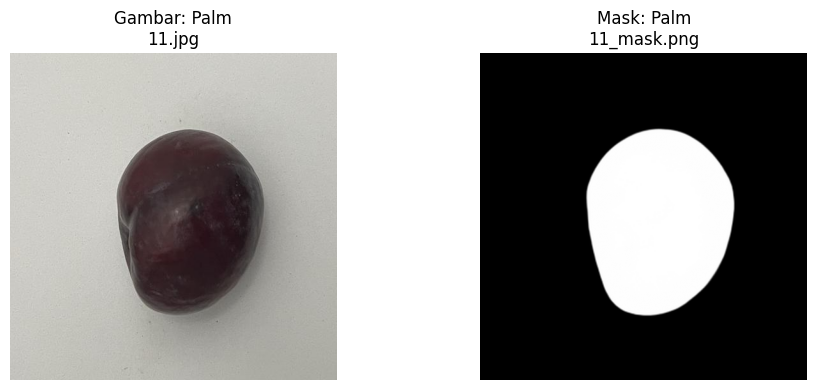


Sampel untuk: Olive


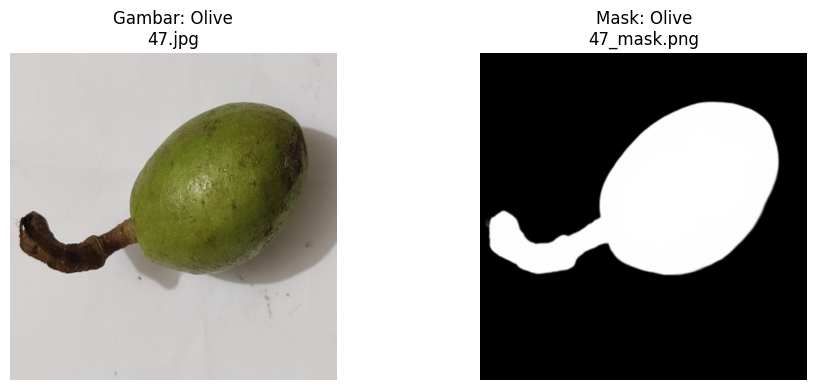


Sampel untuk: Apple_Gala


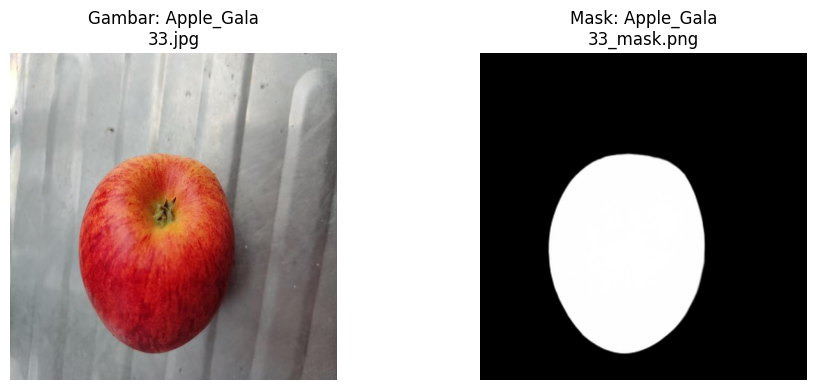


Sampel untuk: Pomegranate


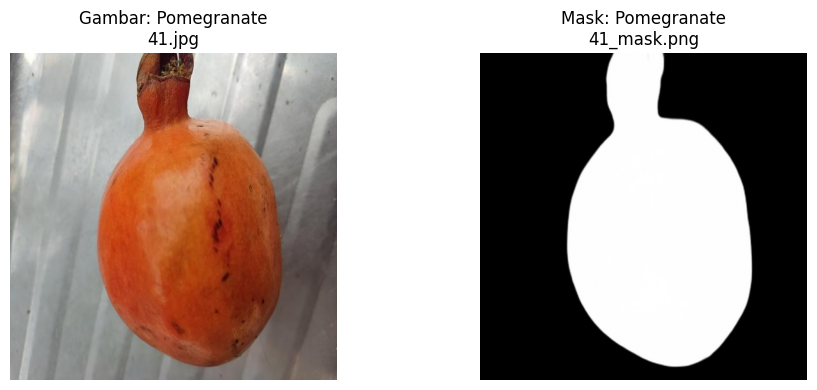


Sampel untuk: Dragon


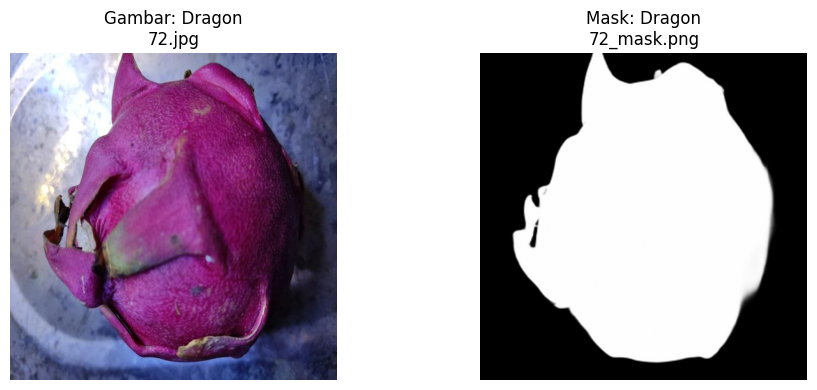

In [15]:
# --- Visualisasi Beberapa Sampel Acak ---

print("Menampilkan 5 sampel acak dari dataset...")
print("=" * 40)

N_SAMPLES = 5

if len(all_fruit_datasets) == 0:
    print("Tidak ada dataset buah untuk ditampilkan.")
elif len(all_fruit_datasets) < N_SAMPLES:
    print(f"Hanya ada {len(all_fruit_datasets)} buah, menampilkan semua...")
    selected_datasets = all_fruit_datasets
else:
    selected_datasets = random.sample(all_fruit_datasets, N_SAMPLES)

for fruit_dataset in selected_datasets:
    print(f"\nSampel untuk: {fruit_dataset['fruit_name']}")
    visualize_single_sample(fruit_dataset)